<a href="https://colab.research.google.com/github/Spaceship-titanic/kaggle_challenge/blob/main/xgboost_test_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [14]:
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [15]:
from sklearn.preprocessing import LabelEncoder

train_df_encoded = train_df.copy()
label_encoders = {}

for col in train_df_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    train_df_encoded[col] = le.fit_transform(train_df_encoded[col])
    label_encoders[col] = le


In [16]:
# Label encode all object/categorical columns
from sklearn.preprocessing import LabelEncoder

train_df_encoded = train_df.copy()
label_encoders = {}

for col in train_df_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    train_df_encoded[col] = le.fit_transform(train_df_encoded[col])
    label_encoders[col] = le


In [19]:
X = train_df_encoded.drop('Transported', axis=1)
y = train_df_encoded['Transported']


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

# Randomized SearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best parameters and model
best_params = random_search.best_params_
print(" Best Hyperparameters:", best_params)

# Predict using best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

# Evaluation
print("\n Tuned XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
 Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 1.0}

 Tuned XGBoost Model Evaluation:
Accuracy: 0.8062104657849338
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       863
        True       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:14:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/tmp/ipython-input-23-3647521019.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp[indices], y=features[indices], palette='viridis')


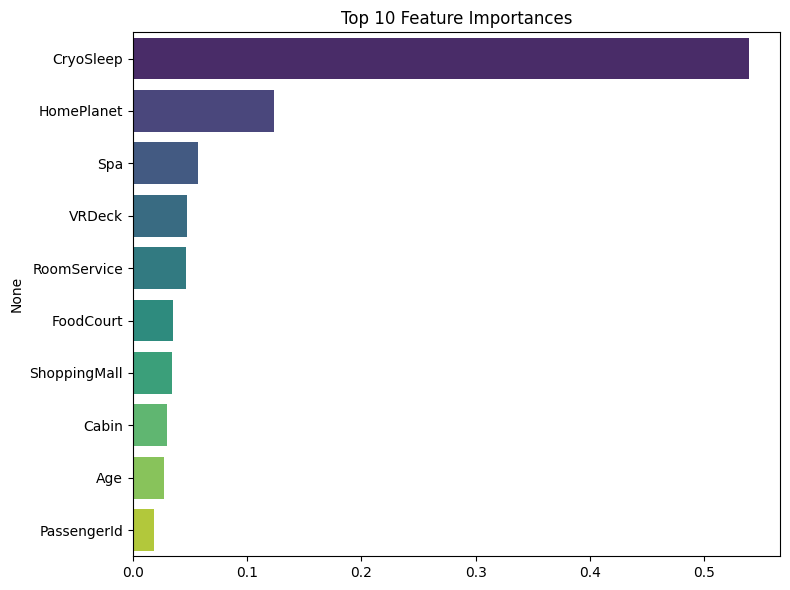

In [23]:
# Assuming best_model is already trained and X is available
feat_imp = best_model.feature_importances_
features = X.columns
indices = np.argsort(feat_imp)[::-1][:10]  # Top 10 features

plt.figure(figsize=(8,6))
plt.title("Top 10 Feature Importances")
sns.barplot(x=feat_imp[indices], y=features[indices], palette='viridis')
plt.tight_layout()
plt.show()


In [24]:
# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

# Apply the same preprocessing steps as training
def preprocess(df):
    df['Name'] = df['Name'].fillna('Unknown')
    df['CryoSleep'] = df['CryoSleep'].fillna(False)
    df['VIP'] = df['VIP'].fillna(False)
    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
    df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Cabin'] = df['Cabin'].fillna('F/0/S')

    services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in services:
        df[col] = df[col].fillna(0)

    # Cabin Split
    df[['Deck','Num','Side']] = df['Cabin'].str.split('/', expand=True)

    # Drop unneeded columns
    df = df.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

    # Encode categoricals
    df = pd.get_dummies(df, drop_first=True)

    return df

X_test = preprocess(test_df)

/tmp/ipython-input-24-849129199.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(False)
/tmp/ipython-input-24-849129199.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False)


In [25]:
# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [26]:
X_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,0,True,0,0,27.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0,0,False,0,0,19.0,False,0.0,9.0,0.0,2823.0,0.0,0
2,0,0,True,0,0,31.0,False,0.0,0.0,0.0,0.0,0.0,0
3,0,0,False,0,0,38.0,False,0.0,6652.0,0.0,181.0,585.0,0
4,0,0,False,0,0,20.0,False,10.0,0.0,635.0,0.0,0.0,0


In [27]:
# Predict
y_pred = best_model.predict(X_test)

y_pred = y_pred.astype(bool)

In [28]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': y_pred
})

submission.to_csv('submission.csv', index=False)
print("✅ Submission file created as 'submission.csv'")

✅ Submission file created as 'submission.csv'
